# Spam Email Detection Using Naive Bayes and LSTM 

In [182]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
from keras import Input
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils import pad_sequences

In [4]:
#Creating a dataframe for ham
path_ham = 'SpamDetection\\ham'

df_ham = pd.DataFrame(columns=['Message', 'Label'])

for file_name in os.listdir(path_ham):
    file_path = os.path.join(path_ham, file_name)

    if os.path.isfile(file_path):
        with open(file_path, 'r',encoding='latin-1') as file:
            ham_content = file.read()
        df_ham = df_ham.append({'Message': ham_content, 'Label': 'ham'}, ignore_index=True)

df_ham.head()

,Message,Label
0,Return-Path: <exmh-workers-admin@spamassassin....,ham
1,From exmh-workers-admin@redhat.com Thu Aug 22...,ham
2,Return-Path: Fool@motleyfool.com\nDelivery-Dat...,ham
3,From exmh-workers-admin@redhat.com Wed Aug 21...,ham
4,From Steve_Burt@cursor-system.com Thu Aug 22 ...,ham


In [5]:
#Creating a dataframe for spam
path_spam= "SpamDetection\\spam"

df_spam = pd.DataFrame(columns=['Message', 'Label'])

for file_name in os.listdir(path_spam):
    file_path = os.path.join(path_spam, file_name)

    if os.path.isfile(file_path):
        with open(file_path, 'r', encoding='latin-1') as file:
            spam_content = file.read()
        df_spam = df_spam.append({'Message': spam_content, 'Label': 'spam'}, ignore_index=True)

df_spam.head()

,Message,Label
0,From ilug-admin@linux.ie Tue Aug 6 11:51:02 ...,spam
1,From 12a1mailbot1@web.de Thu Aug 22 13:17:22 ...,spam
2,From lmrn@mailexcite.com Mon Jun 24 17:03:24 ...,spam
3,From ilug-admin@linux.ie Thu Aug 22 13:27:39 ...,spam
4,From sabrina@mx3.1premio.com Thu Aug 22 14:44...,spam


In [6]:
# Merging both the dataframes
df = pd.concat([df_ham,df_spam])

# Shuffuling the datset, after concating
df = df.sample(frac=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8597 entries, 3024 to 5100
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Message  8597 non-null   object
 1   Label    8597 non-null   object
dtypes: object(2)
memory usage: 201.5+ KB


In [11]:
#Checking how many spam and ham messages we have
df['Label'].value_counts()

ham     6701
spam    1896
Name: Label, dtype: int64

In [13]:
# Checking for duplicate values
duplicates = df.duplicated()
print('Number of duplicated records: ',duplicates.sum())

Number of duplicated records:  141


In [14]:
#Dropping duplicate values
df= df.drop_duplicates()

In [16]:
df

,Message,Label
3024,From spamassassin-devel-admin@lists.sourceforg...,ham
299,From fn@insiq.us Thu Aug 29 11:09:03 2002\nRe...,spam
1091,From rpm-list-admin@freshrpms.net Mon Aug 26 ...,ham
4698,From fork-admin@xent.com Sat Sep 7 21:54:04 ...,ham
4022,From rssfeeds@jmason.org Tue Oct 1 10:37:50 ...,ham
...,...,...
3965,From rssfeeds@jmason.org Tue Oct 1 10:36:45 ...,ham
1454,From razor-users-admin@lists.sourceforge.net ...,ham
1500,From fork-admin@xent.com Tue Sep 17 15:09:23 ...,ham
547,From FreeSoftware-6680b00@yahoo.com Wed Sep 1...,spam


## EDA

In [17]:
#Lets make a length column which counts the length of the message column
df['Length'] = df['Message'].apply(len)

In [18]:
df['Length'].describe()

count      8456.000000
mean       4890.324503
std        7982.379203
min         368.000000
25%        2485.750000
50%        3471.500000
75%        4743.500000
max      300734.000000
Name: Length, dtype: float64

<AxesSubplot:xlabel='Length', ylabel='Count'>

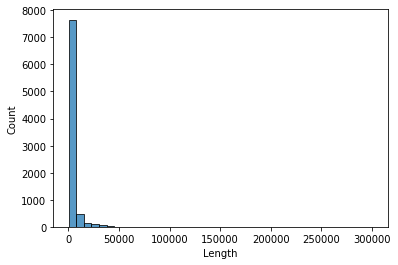

In [20]:
# import matplotlib.pyplot as plt

# plt.hist(x = df["Length"])

sns.histplot(data=df['Length'], bins=40)

In [23]:
df['Length'].describe()

count      8454.000000
mean       4855.657795
std        7305.970904
min         368.000000
25%        2486.000000
50%        3471.500000
75%        4742.750000
max      232375.000000
Name: Length, dtype: float64

 * We see that the average length of our messages is 4890 characters and the maximum characters of a message is 300734.

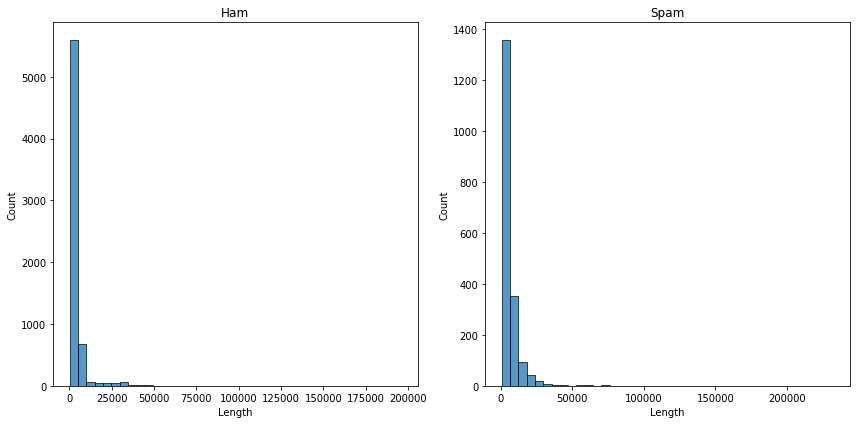

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df[df['Label'] == 'ham'], x='Length', bins=40, ax=axes[0])
axes[0].set_title('Ham')
sns.histplot(data=df[df['Label'] == 'spam'], x='Length', bins=40, ax=axes[1])
axes[1].set_title('Spam')
plt.tight_layout()

In [ ]:
full_str = ''
stopwords = set(STOPWORDS)

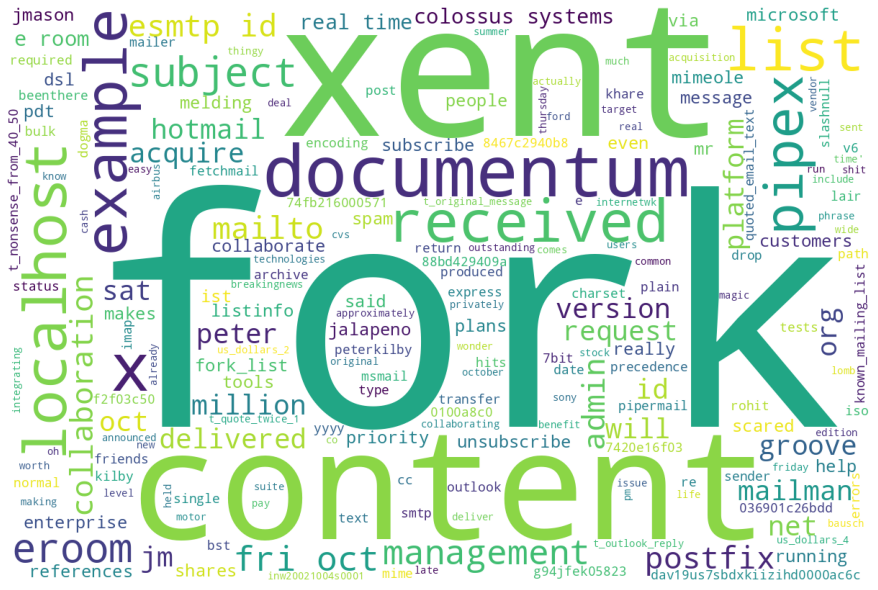

In [200]:
# Ham word clouds
for val in df[df['Label']=='ham'].Message:
    tokens = str(val).split()
    full_str = " ".join([i.lower() for i in tokens])+" "

wordcloud = WordCloud(width = 1200, height = 800,background_color ='white', stopwords = stopwords, min_font_size = 10).generate(full_str)

plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

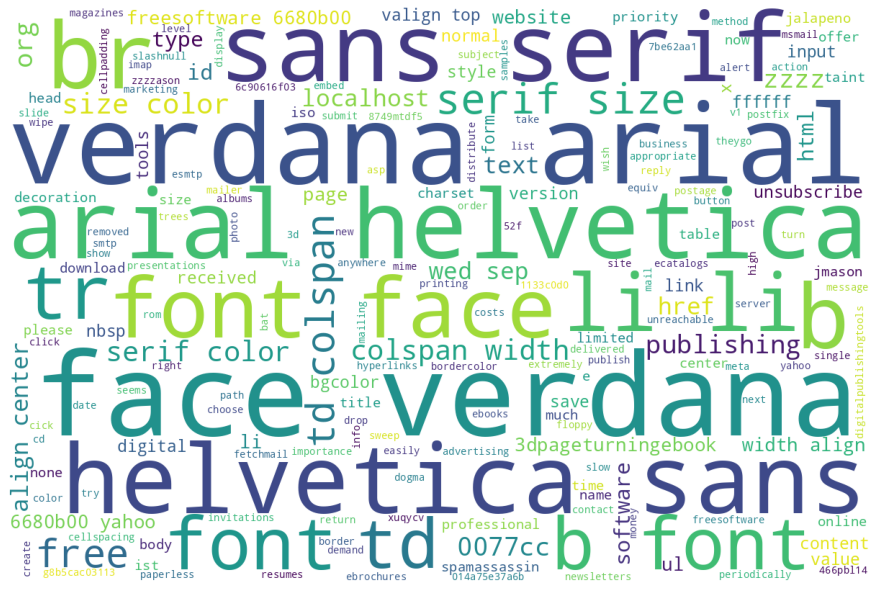

In [204]:
# Spam word clouds
for val in df[df['Label']=='spam'].Message:
    tokens = str(val).split()
    full_str = " ".join([i.lower() for i in tokens])+" "

wordcloud = WordCloud(width = 1200, height = 800,background_color ='white', stopwords = stopwords, min_font_size = 10).generate(full_str)

plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Preprocessing Data

In [26]:
#Lowercase of letters
def lowercase_letters(text):
    return text.lower()

In [27]:
# Removing any numbers from our text
def removing_numbers(text):
    text = ''.join(char for char in text if not char.isnumeric())
    return text

In [28]:
#Removing punctuations and special characters
def remove_punc(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'_', ' ', text)
    return text

In [29]:
#Removing irrelevant https links
def remove_url(text):
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text)
    text = re.sub(r'&amp;', ' ', text)
    text= re.sub("[^a-zA-Z]+", " ",text)

    return text

In [30]:
#Removing Stop Words
def removing_stopwords(text):
    text = text.split()
    stops = set(stopwords.words('english'))
    text = [w for w in text if not w in stops]
    return ' '.join(text)

In [31]:
#Applying Lemmatizer
def lemmatizer(text):
    text = text.split()
    lemmatizer_text = WordNetLemmatizer()
    lem_list = [lemmatizer_text.lemmatize(word) for word in text]
    return " ".join(lem_list)

In [33]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bansa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bansa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
#Applying all the functions to our Message column
df['Cleaned Message']= df['Message'].apply(lambda x: lowercase_letters(x))
df['Cleaned Message']= df['Cleaned Message'].apply(lambda x: removing_numbers(x))
df['Cleaned Message']= df['Cleaned Message'].apply(lambda x: remove_punc(x))
df['Cleaned Message']= df['Cleaned Message'].apply(lambda x: remove_url(x))
df['Cleaned Message']= df['Cleaned Message'].apply(lambda x: removing_stopwords(x))
df['Cleaned Message']= df['Cleaned Message'].apply(lambda x: lemmatizer(x))

In [35]:
df['Message']

3024    From spamassassin-devel-admin@lists.sourceforg...
299     From fn@insiq.us  Thu Aug 29 11:09:03 2002\nRe...
1091    From rpm-list-admin@freshrpms.net  Mon Aug 26 ...
4698    From fork-admin@xent.com  Sat Sep  7 21:54:04 ...
4022    From rssfeeds@jmason.org  Tue Oct  1 10:37:50 ...
                              ...                        
3965    From rssfeeds@jmason.org  Tue Oct  1 10:36:45 ...
1454    From razor-users-admin@lists.sourceforge.net  ...
1500    From fork-admin@xent.com  Tue Sep 17 15:09:23 ...
547     From FreeSoftware-6680b00@yahoo.com  Wed Sep 1...
5100    From fork-admin@xent.com  Sat Oct  5 12:38:50 ...
Name: Message, Length: 8454, dtype: object

In [36]:
df['Cleaned Message']

3024    spamassassin devel admin list sourceforge net ...
299     fn insiq u thu aug return path fn insiq u deli...
1091    rpm list admin freshrpms net mon aug return pa...
4698    fork admin xent com sat sep return path fork a...
4022    rssfeeds jmason org tue oct return path rssfee...
                              ...                        
3965    rssfeeds jmason org tue oct return path rssfee...
1454    razor user admin list sourceforge net tue aug ...
1500    fork admin xent com tue sep return path fork a...
547     freesoftware b yahoo com wed sep return path f...
5100    fork admin xent com sat oct return path fork a...
Name: Cleaned Message, Length: 8454, dtype: object

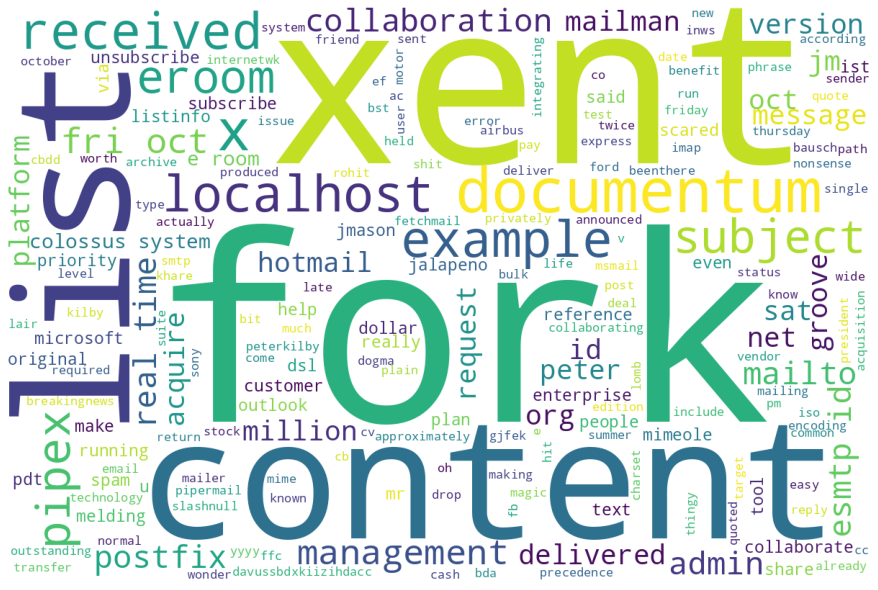

In [201]:
# Ham word clouds
for val in df[df['Label']=='ham']['Cleaned Message']:
    tokens = str(val).split()
    full_str = " ".join([i.lower() for i in tokens])+" "

wordcloud = WordCloud(width = 1200, height = 800,background_color ='white', stopwords = stopwords, min_font_size = 10).generate(full_str)

plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

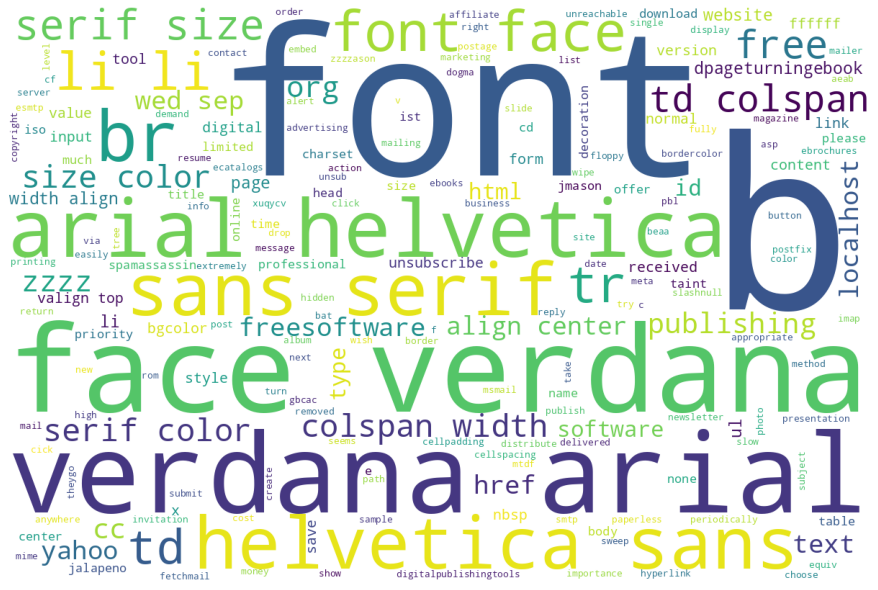

In [202]:
# Spam word clouds
for val in df[df['Label']=='spam']['Cleaned Message']:
    tokens = str(val).split()
    full_str = " ".join([i.lower() for i in tokens])+" "

wordcloud = WordCloud(width = 1200, height = 800,background_color ='white', stopwords = stopwords, min_font_size = 10).generate(full_str)

plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

#### Observation:
- The spam messages seems to have more font styles in their message body

In [50]:
# Using Label Encoder to convert Ham and Spam into 0 and 1 values

label_encoder = LabelEncoder()
target_enc = label_encoder.fit_transform(df['Label'])

# y_val_encoded = label_encoder.transform(y_val)
# y_test_encoded = label_encoder.transform(y_test)

## Data Splitting

In [48]:
df

,Message,Label,Length,Cleaned Message
3024,From spamassassin-devel-admin@lists.sourceforg...,ham,4711,spamassassin devel admin list sourceforge net ...
299,From fn@insiq.us Thu Aug 29 11:09:03 2002\nRe...,spam,9943,fn insiq u thu aug return path fn insiq u deli...
1091,From rpm-list-admin@freshrpms.net Mon Aug 26 ...,ham,3667,rpm list admin freshrpms net mon aug return pa...
4698,From fork-admin@xent.com Sat Sep 7 21:54:04 ...,ham,2607,fork admin xent com sat sep return path fork a...
4022,From rssfeeds@jmason.org Tue Oct 1 10:37:50 ...,ham,1017,rssfeeds jmason org tue oct return path rssfee...
...,...,...,...,...
3965,From rssfeeds@jmason.org Tue Oct 1 10:36:45 ...,ham,1062,rssfeeds jmason org tue oct return path rssfee...
1454,From razor-users-admin@lists.sourceforge.net ...,ham,4458,razor user admin list sourceforge net tue aug ...
1500,From fork-admin@xent.com Tue Sep 17 15:09:23 ...,ham,2312,fork admin xent com tue sep return path fork a...
547,From FreeSoftware-6680b00@yahoo.com Wed Sep 1...,spam,5179,freesoftware b yahoo com wed sep return path f...


In [65]:
# Taking out a validation set (10% of data)
X_train, X_val, y_train, y_val = train_test_split(df['Cleaned Message'], target_enc, stratify =target_enc, test_size=0.1, random_state=42)

In [66]:
# Splitting train data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [67]:
X_train.shape, X_test.shape

((6086,), (1522,))

In [137]:
# Converting our Message data into tfidf matrix form such that it can be used for modeling
vectorizer = TfidfVectorizer()
train_tfidf = vectorizer.fit_transform(X_train)
test_tfidf = vectorizer.transform(X_test)
val_tfidf = vectorizer.transform(X_val)

In [133]:
def acc_metrics(y_true, y_pred, y_pred_prob=False):

    if y_pred_prob is not False:
        print(f'AUC score: {roc_auc_score(y_true, y_pred_prob)}')

        fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
    
    print('Accuracy\t: ', round(accuracy_score(y_true,y_pred),3))
    print('Precision\t: ', round(precision_score(y_true,y_pred),3))
    print('Recall\t\t: ', round(recall_score(y_true,y_pred),3))
    print('F1 Score\t: ', round(f1_score(y_true,y_pred),3))

#     print(classification_report(y_test_encoded, y_predictions_smote))
    cmatrx = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(conf_mat=confusion_matrix(y_true, y_pred))
#     plt.imshow(cmatrx)
#     plt.title("Confusion Matrix Naive Bayes")
#     ticks = np.arange(2)
#     plt.xticks(ticks,['Class 0', 'Class 1'])
#     plt.yticks(ticks,['Class 0', 'Class 1'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.show()

### Base Naive Bayes Model

In [138]:
#Modeling for validation data
nb = MultinomialNB()
nb.fit(train_tfidf, y_train)

MultinomialNB()

Accuracy	:  0.895
Precision	:  0.947
Recall		:  0.561
F1 Score	:  0.705


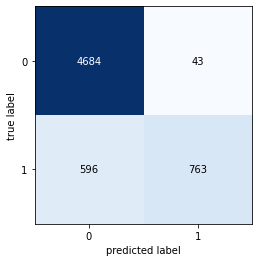

In [139]:
# Training Accuracy
y_train_pred = nb.predict(train_tfidf)
acc_metrics(y_train, y_train_pred)

Accuracy	:  0.889
Precision	:  0.963
Recall		:  0.532
F1 Score	:  0.685


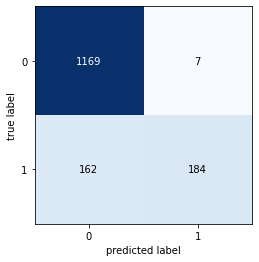

In [140]:
# Testing Accuracy
y_test_pred = nb.predict(test_tfidf)
acc_metrics(y_test, y_test_pred)

Accuracy	:  0.879
Precision	:  0.923
Recall		:  0.505
F1 Score	:  0.653


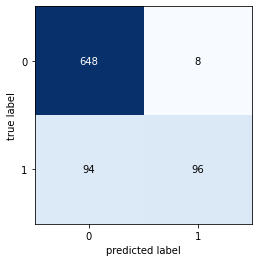

In [144]:
# Validation Accuracy
y_val_pred = nb.predict(val_tfidf)
acc_metrics(y_val, y_val_pred)

#### Observations:
* Even though accuracy & precision seems high, recall seems to be low because False positives are high. This could be due to imbalance in classes, we will do oversampling using SMOTE

### Naive Bayes Model with SMOTE

In [151]:
# Performing over sampling

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(train_tfidf, y_train)

In [162]:
X_train_resampled.shape, 

((9454, 106429),)

<AxesSubplot:>

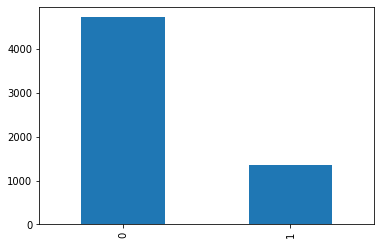

In [167]:
# Before Oversampling
pd.Series(y_train).value_counts().plot(kind='bar')

<AxesSubplot:>

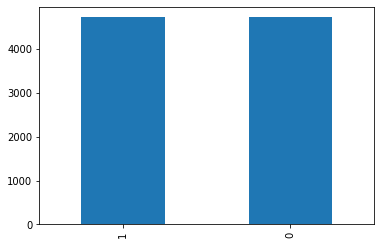

In [168]:
# After Oversampling
pd.Series(y_train_resampled).value_counts().plot(kind='bar')

In [171]:
# Modeling with resampled data using SMOTE

nb_smote = nb.fit(X_train_resampled, y_train_resampled)

Accuracy	:  0.973
Precision	:  0.972
Recall		:  0.974
F1 Score	:  0.973


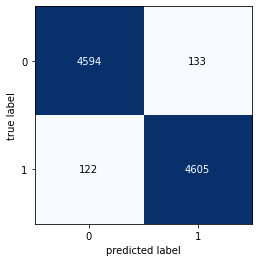

In [173]:
# Training Accuracy
y_train_pred = nb_smote.predict(X_train_resampled)
acc_metrics(y_train_resampled, y_train_pred)

Accuracy	:  0.964
Precision	:  0.908
Recall		:  0.936
F1 Score	:  0.922


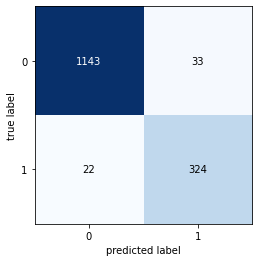

In [175]:
# Testing Accuracy
y_test_pred = nb_smote.predict(test_tfidf)
acc_metrics(y_test, y_test_pred)

Accuracy	:  0.966
Precision	:  0.897
Recall		:  0.958
F1 Score	:  0.926


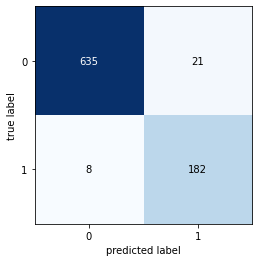

In [176]:
# Validation Accuracy
y_val_pred = nb_smote.predict(val_tfidf)
acc_metrics(y_val, y_val_pred)

#### Observations:
* Oversampling seems to fixed the issue. Now we get ~90% of accuracy across metrics

### Base LSTM Model

In [50]:
X_train_resampled.shape, y_train_resampled.shape

((9484, 83916), (9484,))

In [51]:
# Tokenizing the data
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)
messages_tok_train = tokenizer.texts_to_sequences(X_train)
messages_tok_val = tokenizer.texts_to_sequences(X_val)
messages_tok_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# all the words and their frequency
tokenizer.index_word

In [ ]:
tokenizer.index_word.keys()

In [54]:
# tried to plot all the words and their frequency

#plt.bar(tokenizer.index_word.keys(), tokenizer.index_word.values(), align='center')

In [55]:
# finding the length of largest sequence
max_len_seq = max([len(i) for i in messages_tok_train])

# pedding the sqquences
padded_seq = pad_sequences(messages_tok_train, maxlen=max_len_seq, padding = "pre")
padded_seq

array([[    0,     0,     0, ...,    27,   188,    79],
       [    0,     0,     0, ...,    45,    65,    13],
       [    0,     0,     0, ...,    65,    19,   100],
       ...,
       [    0,     0,     0, ...,    65,    19,   100],
       [    0,     0,     0, ...,     6, 37820,    79],
       [    0,     0,     0, ...,    45,    65,    13]], dtype=int32)

In [56]:
TOT_SIZE = len(tokenizer.word_index)+1

In [57]:
# Building the lstm model

lstm = Sequential()

lstm.add(Embedding(TOT_SIZE, 64, input_length=max_len_seq))

lstm.add(LSTM(64))

lstm.add(Dense(64, activation="relu"))

lstm.add(Dense(1, activation="sigmoid"))

lstm.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22220, 64)         5372288   
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,409,537
Trainable params: 5,409,537
Non-trainable params: 0
_________________________________________________________________


In [58]:
# training the model
lstm.fit(padded_seq,y_train,epochs=5,batch_size=10)

Epoch 1/5
609/609 [==============================] - 436s 695ms/step - loss: 0.1104 - accuracy: 0.9604
Epoch 2/5
609/609 [==============================] - 325s 533ms/step - loss: 0.0194 - accuracy: 0.9946
Epoch 3/5
609/609 [==============================] - 300s 493ms/step - loss: 0.0122 - accuracy: 0.9961
Epoch 4/5
609/609 [==============================] - 283s 465ms/step - loss: 0.0094 - accuracy: 0.9979
Epoch 5/5
609/609 [==============================] - 274s 450ms/step - loss: 0.0041 - accuracy: 0.9985


In [59]:
# padding the test and validation split

test_padded_seq = pad_sequences(messages_tok_test, maxlen=max_len_seq, padding = "pre")
val_padded_seq = pad_sequences(messages_tok_val, maxlen=max_len_seq, padding = "pre")

In [60]:
test_padded_seq.shape

(1522, 22220)

In [61]:
# Measuring the the accuracy for the test and validation data

test_acc = lstm.evaluate(test_padded_seq, y_test)
print("test accuracy : " ,test_acc[1])


val_acc = lstm.evaluate(val_padded_seq, y_val)
print("Validation accuracy : ", val_acc[1])


48/48 [==============================] - 11s 226ms/step - loss: 0.0751 - accuracy: 0.9842
test accuracy :  0.9842312932014465
27/27 [==============================] - 6s 234ms/step - loss: 0.0584 - accuracy: 0.9882
Validation accuracy :  0.9881796836853027


In [ ]:
test_padded_seq.shape

48/48 [==============================] - 11s 228ms/step
AUC score: 0.9987593081711487


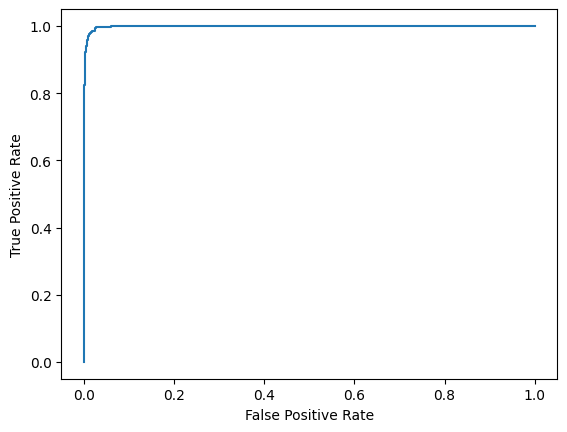

Accuracy	:  0.984
Precision	:  0.962
Recall		:  0.972
F1 Score	:  0.967


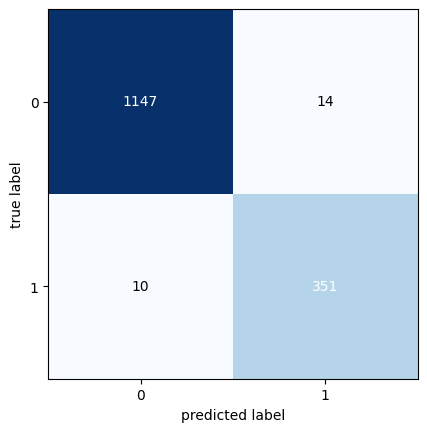

In [64]:
# Testing accuracy
y_test_pred_prob = lstm.predict(test_padded_seq)
y_test_pred=np.where(y_test_pred>0.5,1,0)
acc_metrics(y_test,y_test_pred,y_test_pred_prob)

27/27 [==============================] - 6s 212ms/step
AUC score: 0.9990853658536585


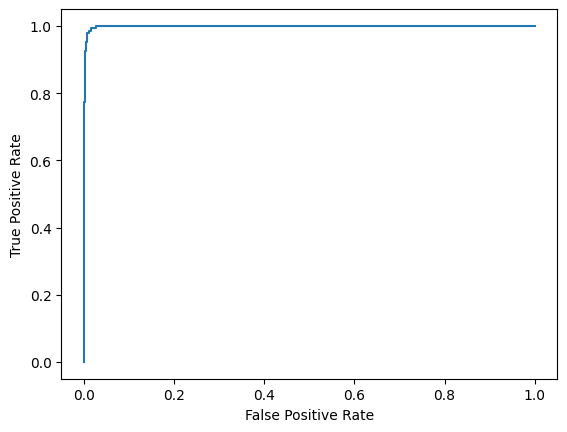

Accuracy	:  0.969
Precision	:  0.906
Recall		:  0.963
F1 Score	:  0.934


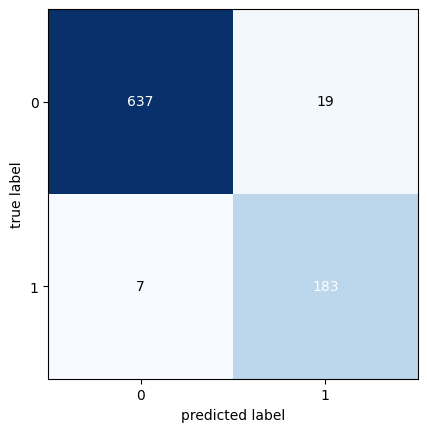

In [65]:
# Validating accuracy
y_val_pred_prob = lstm.predict(val_padded_seq)
y_val_pred=np.where(y_val_pred>0.5,1,0)
acc_metrics(y_val,y_val_pred,y_val_pred_prob)

### LSTM Model with SMOTE

In [66]:
# initializing smote for over sampeling

smote_tok = SMOTE()

X_train_resampled_tok, y_train_resampled_tok = smote_tok.fit_resample(padded_seq, y_train)

In [67]:
print(padded_seq.shape)
print(X_train_resampled_tok.shape)

(6087, 22220)
(9484, 22220)


In [68]:
# Building the lstm model with smote features

lstm_smote = Sequential()

lstm_smote.add(Embedding(TOT_SIZE, 64, input_length=max_len_seq))

lstm_smote.add(LSTM(64))

lstm_smote.add(Dense(64, activation="relu"))

lstm_smote.add(Dense(1, activation="sigmoid"))

lstm_smote.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
lstm_smote.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 22220, 64)         5372288   
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,409,537
Trainable params: 5,409,537
Non-trainable params: 0
_________________________________________________________________


In [69]:
# retraining with the new resampled data

lstm_smote.fit(X_train_resampled_tok,y_train_resampled_tok,epochs=5,batch_size=10)

Epoch 1/5
949/949 [==============================] - 573s 598ms/step - loss: 0.1370 - accuracy: 0.9507
Epoch 2/5
949/949 [==============================] - 484s 509ms/step - loss: 0.0173 - accuracy: 0.9963
Epoch 3/5
949/949 [==============================] - 459s 484ms/step - loss: 0.0149 - accuracy: 0.9962
Epoch 4/5
949/949 [==============================] - 441s 465ms/step - loss: 0.0053 - accuracy: 0.9988
Epoch 5/5
949/949 [==============================] - 430s 454ms/step - loss: 0.0054 - accuracy: 0.9986


In [70]:
# pedding the new test and validation sets
test_padded_seq = pad_sequences(messages_tok_test, maxlen=max_len_seq, padding = "pre")
val_padded_seq = pad_sequences(messages_tok_val, maxlen=max_len_seq, padding = "pre")

In [72]:
samp_test_acc = lstm_smote.evaluate(test_padded_seq, y_test)
print("test accuracy : " ,samp_test_acc[1])


samp_val_acc = lstm_smote.evaluate(val_padded_seq, y_val)
print("Validation accuracy : ", samp_val_acc[1])

48/48 [==============================] - 14s 285ms/step - loss: 0.0987 - accuracy: 0.9823
test accuracy :  0.9822601675987244
27/27 [==============================] - 6s 221ms/step - loss: 0.0794 - accuracy: 0.9858
Validation accuracy :  0.9858155846595764


48/48 [==============================] - 11s 229ms/step
AUC score: 0.9969424104256288


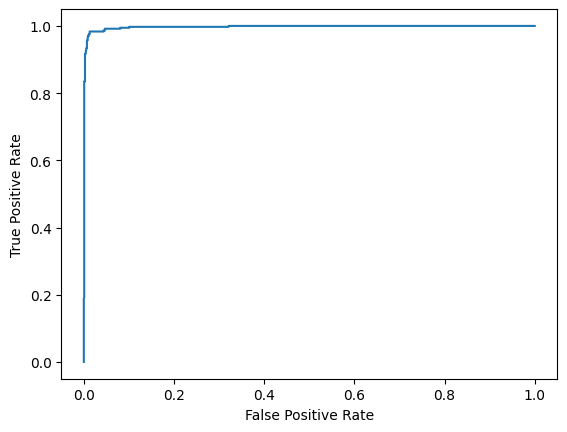

Accuracy	:  0.984
Precision	:  0.962
Recall		:  0.972
F1 Score	:  0.967


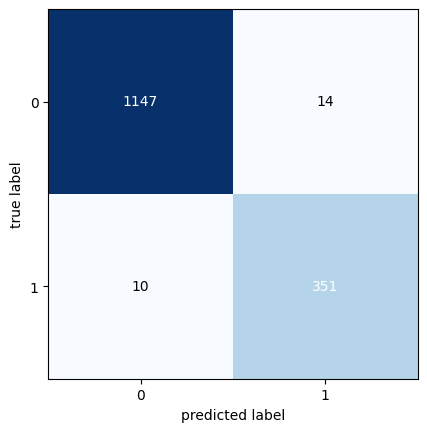

In [73]:
# Testing accuracy
y_test_pred_prob = lstm_smote.predict(test_padded_seq)
y_test_pred=np.where(y_test_pred>0.5,1,0)
acc_metrics(y_test,y_test_pred,y_test_pred_prob)

27/27 [==============================] - 6s 214ms/step
AUC score: 0.9963254172015404


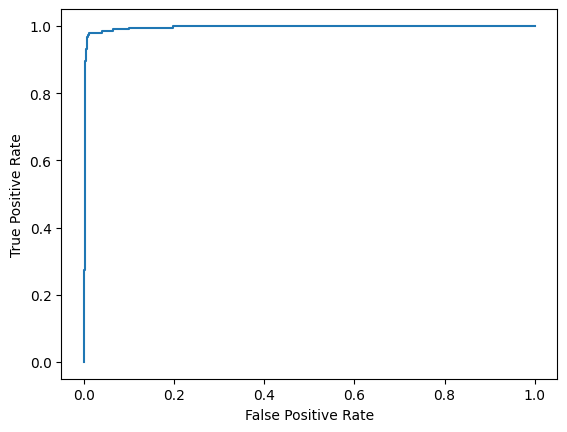

Accuracy	:  0.969
Precision	:  0.906
Recall		:  0.963
F1 Score	:  0.934


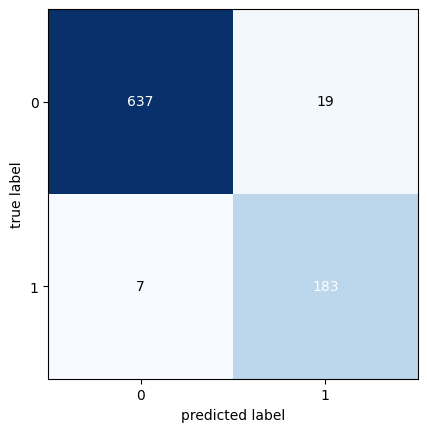

In [74]:
# Validating accuracy
y_val_pred_prob = lstm_smote.predict(val_padded_seq)
y_val_pred=np.where(y_val_pred>0.5,1,0)
acc_metrics(y_val,y_val_pred,y_val_pred_prob)

#### Observations:
* Base LSTM scored good across metrics as compared to NB model
* Although it took significant more time & resources to train

### What more could be done:
- We can try more heavily on feature engineering side - try creating custom meaningful feature by analyzing the mail
- We can try to treat data in different way - try snipping large messages, creating meaningful vectors using Doc2Vec or LLMs like BERT